In [1]:
import logging
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

e:\BSCS 3-3b\AI\Transformers\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load dataset
df = pd.read_csv('data/en_hv_dataset.csv')
df

,en,hv
0,teen depression why .,depresyon sa mga tin - edyer ngaa .
1,what can help .,ano ang makabulig sa ila .
2,the compound heat shield of the saharan silver...,ang panagang sa init sang saharan silver ant .
3,do you have a feast constantly .,may ara ka bala sing dalayon nga piesta .
4,all the days of the afflicted one are bad but ...,"ang tanan nga adlaw sang napiotan malaut , apa..."
...,...,...
5251,i take the heavens and the earth as witnesses ...,ginahimo ko ang langit kag ang duta nga mga sa...
5252,"while you throw all your anxiety on him , beca...",samtang ginatugyan ninyo sa iya ang tanan niny...
5253,"draw close to god , and he will draw close to ...","magpalapit kamo sa dios , kag magapalapit sia ..."
5254,"cleanse your hands , you sinners , and purify ...","tinlui ang inyo mga kamot , kamo nga makasasal..."


In [3]:
en_texts = df['en'].values # get en column data
hv_texts = df['hv'].values # get hv column data

# ensure string data type
en_samples = []
for txt in en_texts:
    en_samples.append(str(txt)) 
    
hv_samples = []
for txt in hv_texts:
    hv_samples.append(str(txt))

# divide the dataset into training and testing sets
en_train = en_samples[-5000:]
en_test = en_samples[:256]

hv_train = hv_samples[-5000:]
hv_test = hv_samples[:256]

en_train_tensor = tf.constant(en_train)
hv_train_tensor = tf.constant(hv_train)

en_test_tensor = tf.constant(en_test)
hv_test_tensor = tf.constant(hv_test)

train_examples = tf.data.Dataset.from_tensor_slices((en_train_tensor, hv_train_tensor)) # create train tensors
val_examples = tf.data.Dataset.from_tensor_slices((en_test_tensor, hv_test_tensor)) # create test tensors

len(val_examples)


256

In [4]:
for en_examples, hv_examples in train_examples.batch(3).take(1):
    print('> Examples in English:')
    for en in en_examples.numpy():
        print(en.decode('utf-8'))
    print()

    print('> Examples in Hiligaynon:')
    for hv in hv_examples.numpy():
        print(hv.decode('utf-8'))

> Examples in English:
the elders put the welfare of the congregation above their own , said a witness named babita . 
we were touched to see such love . 
the day after the earthquake , the three members of the committee overseeing the work of jehovah ' s witnesses in nepal , in conjunction with traveling ministers , or circuit overseers , began visiting congregations to assess needs and support the local elders . 

> Examples in Hiligaynon:
gin - una sang mga gulang ang kaayuhan sang kongregasyon sangsa ila kaugalingon , siling sang saksi nga si babita . 
natandog gid kami sa gugma nga ila ginpakita . 
pagkaaga sa tapos sang linog , ang tatlo ka miembro sang komite nga nagadumala sa hilikuton sang mga saksi ni jehova sa nepal , upod ang nagalakbay nga mga ministro , ukon manugtatap sang sirkito , nagbisita sa mga kongregasyon para mahibaluan ang ila mga kinahanglanon kag mabuligan ang mga gulang sa sina nga lugar . 


In [5]:
# Convert text dataset into tokens
model_name = 'ted_hrlr_translate_hv_en_converter'
tokenizers = tf.saved_model.load(model_name)

encoded = tokenizers.hv.tokenize(hv_examples)  # encode hiligaynon text to its corresponding token IDs

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
    print(row)
    
round_trip = tokenizers.hv.detokenize(encoded) # decode the token IDs back to readable words
print('> This is human-readable text:')
for line in round_trip.numpy():
    print(line.decode('utf-8'))

> This is a padded-batch of token IDs:
[2, 258, 6, 181, 41, 42, 1257, 39, 313, 41, 606, 168, 56, 119, 5, 156, 41, 212, 38, 66, 11, 92, 825, 213, 7, 3]
[2, 53, 194, 164, 89, 50, 139, 40, 166, 38, 56, 730, 7, 3]
[2, 103, 281, 92, 307, 40, 758, 41, 642, 5, 39, 580, 46, 748, 41, 69, 151, 309, 144, 38, 694, 130, 1231, 255, 555, 40, 602, 41, 42, 212, 78, 99, 40, 23, 144, 318, 127, 5, 196, 39, 694, 555, 142, 362, 38, 42, 22, 335, 983, 336, 5, 54, 62, 1231, 89, 213, 213, 310, 41, 66, 167, 986, 107, 5, 247, 825, 1104, 213, 40, 42, 606, 71, 354, 39, 56, 42, 267, 43, 515, 39, 42, 1257, 40, 217, 38, 210, 7, 3]
> This is human-readable text:
gin - una sang mga gulang ang kaayuhan sang kongregasyon sangsa ila kaugalingon , siling sang saksi nga si babita .
natandog gid kami sa gugma nga ila ginpakita .
pagkaaga sa tapos sang linog , ang tatlo ka miembro sang komite nga nagadumala sa hilikuton sang mga saksi ni jehova sa nepal , upod ang nagalakbay nga mga ministro , ukon manugtatap sang sirkito , na

In [6]:
# Prepare input and label batches
MAX_TOKENS = 128
BUFFER_SIZE = 20000
BATCH_SIZE = 32

def prepare_batch(en, hv):
    en = tokenizers.en.tokenize(en)      # Output is ragged.
    en = en[:, :MAX_TOKENS]              # Trim to MAX_TOKENS.
    en = en.to_tensor()                  # Convert to 0-padded dense Tensor

    hv = tokenizers.hv.tokenize(hv)
    hv = hv[:, :(MAX_TOKENS+1)]
    hv_inputs = hv[:, :-1].to_tensor()   # Drop the [END] tokens
    hv_labels = hv[:, 1:].to_tensor()    # Drop the [START] tokens

    return (en, hv_inputs), hv_labels

def make_batches(ds):
    return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))
    
# Create input and label batches
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

for (en, hv), hv_labels in train_batches.take(1):
    break

print(en.shape)
print(hv.shape)
print(hv_labels.shape)

print('> We have the following input tensors:')
print(en[0][:10])
print(hv[0][:10])

print('> We have the following label tensors:')
print(hv_labels[0][:10])

(32, 42)
(32, 54)
(32, 54)
> We have the following input tensors:
tf.Tensor([   2  494   45   38  993   41   30 1194  525 1084], shape=(10,), dtype=int64)
tf.Tensor([  2  45  51 600  39 184   5  39  57  38], shape=(10,), dtype=int64)
> We have the following label tensors:
tf.Tensor([ 45  51 600  39 184   5  39  57  38 470], shape=(10,), dtype=int64)


In [7]:
# Prepare model components

# Positional Encoding
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x
    
    def get_config(self):
        return {
            'd_model': self.d_model,
            'pos_encoding': self.pos_encoding.numpy()
        }

# Self-Attention Mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
# Feed Forward Network
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

# Training Scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            'd_model': self.d_model,
            'warmup_steps': self.warmup_steps
        }

In [8]:
# Building the actual model

# The Encoder Block
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.
    
    def get_config(self):
        return {
            'd_model': self.d_model,
            'num_layers': self.num_layers
        }
    
# The Decoder Block
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

    def get_config(self):
        return {
            'd_model': self.d_model,
            'num_layers': self.num_layers,
            'last_attn_scores': self.last_attn_scores
        }
    
# The Transformer Model
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)     # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)     # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [9]:
# Set the parameters
NUM_LAYERS = 3
D_MODEL = 128
DFF = 512
NUM_HEADS = 8
DROPOUT_RATE = 0.1

# Initiate the Model
transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.hv.get_vocab_size().numpy(),
    dropout_rate=DROPOUT_RATE)

model = transformer((en, hv))

transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2162688   
                                                                 
 decoder (Decoder)           multiple                  3730816   
                                                                 
 dense_12 (Dense)            multiple                  169764    
                                                                 
Total params: 6,063,268
Trainable params: 6,063,268
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Let's start training!

learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Loss Function
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

# Accuracy metric
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

transformer.fit(train_batches, epochs=20, validation_data=val_batches)

# simulate model
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.en.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers.hv.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizers.hv.detokenize(output)[0]  # Shape: `()`.

        tokens = tokenizers.hv.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights
    
translator = Translator(tokenizers, transformer)

# export model
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result, tokens, attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)
        return (result, tokens, attention_weights)
    
translator = ExportTranslator(translator)

tf.saved_model.save(translator, export_dir='en_to_hv_translator')

Epoch 1/20
157/157 [==============================] - 49s 248ms/step - loss: 6.7753 - masked_accuracy: 0.0389 - val_loss: 6.3406 - val_masked_accuracy: 0.0610
Epoch 2/20
157/157 [==============================] - 37s 238ms/step - loss: 5.8527 - masked_accuracy: 0.1047 - val_loss: 5.5057 - val_masked_accuracy: 0.1119
Epoch 3/20
157/157 [==============================] - 37s 238ms/step - loss: 5.1995 - masked_accuracy: 0.1474 - val_loss: 4.9643 - val_masked_accuracy: 0.1636
Epoch 4/20
157/157 [==============================] - 37s 233ms/step - loss: 4.6459 - masked_accuracy: 0.1940 - val_loss: 4.5731 - val_masked_accuracy: 0.1862
Epoch 5/20
157/157 [==============================] - 37s 236ms/step - loss: 4.2823 - masked_accuracy: 0.2223 - val_loss: 4.3369 - val_masked_accuracy: 0.2143
Epoch 6/20
157/157 [==============================] - 37s 238ms/step - loss: 4.0335 - masked_accuracy: 0.2478 - val_loss: 4.1533 - val_masked_accuracy: 0.2354
Epoch 7/20
157/157 [==========================

INFO:tensorflow:Assets written to: en_to_hv_translator\assets


INFO:tensorflow:Assets written to: en_to_hv_translator\assets


In [44]:
# Call saved model
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.util import ngrams

reloaded = tf.saved_model.load('en_to_hv_translator')

def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')
    print()

# show the relationship of each words
def plot_attention_head(sentence, translated_tokens, attention_weights):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]
    
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.en.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.en.lookup(in_tokens)[0]
    
    head = 0
    # Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
    attention_heads = tf.squeeze(attention_weights, 0)
    attention = attention_heads[head]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
        labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)
    
# show the rouge score of the prediction and ground truth
def rouge_score(reference, hypothesis):
    # Convert reference and hypothesis sentences to lowercase
    reference = reference.numpy().decode("utf-8").lower()
    hypothesis = hypothesis.lower()

    # Tokenize the reference and hypothesis into words
    reference_tokens = reference.split()
    hypothesis_tokens = hypothesis.split()

    # Compute unigram (n-gram of 1) overlap using sets
    reference_grams = set(ngrams(reference_tokens, 1))
    hypothesis_grams = set(ngrams(hypothesis_tokens, 1))

    # Calculate precision, recall, and F1-score
    precision = len(reference_grams.intersection(hypothesis_grams)) / len(hypothesis_grams)
    recall = len(reference_grams.intersection(hypothesis_grams)) / len(reference_grams)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)  # Add a small value to avoid division by zero

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Input:         : all of us want to be happy and content in our life . 
Prediction     : gusto naton nga mangin malipayon kita kag mangin kontento .
Ground truth   : gusto naton mangin malipayon kag kontento . 

Precision: 1.0
Recall: 0.7777777777777778
F1-score: 0.8749999507812528


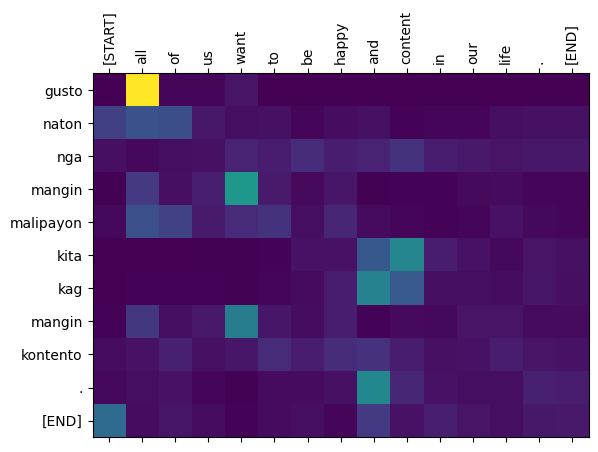

In [45]:
sentence = 'all of us want to be happy and content in our life . '
ground_truth = 'gusto naton mangin malipayon kag kontento . '
translated_text, translated_tokens, attention_weights = reloaded(sentence)
plot_attention_head(sentence, translated_tokens, attention_weights)
print_translation(sentence, translated_text, ground_truth)
rouge_score(translated_text, ground_truth)

Input:         : people around the world are finding ways to be happy . 
Prediction     : sa madamo nga tawo ang naga - paagi sa kalibutan mangin malipayon .
Ground truth   : ang mga tawo sa bilog nga kalibutan nagapangita sing paagi mangin malipayon . 

Precision: 0.6923076923076923
Recall: 0.75
F1-score: 0.7199999500800034


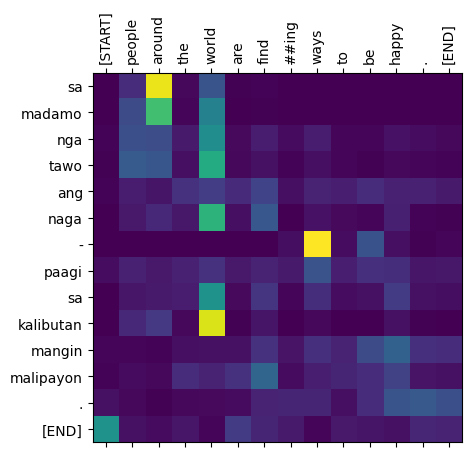

In [46]:
sentence = 'people around the world are finding ways to be happy . '
ground_truth = 'ang mga tawo sa bilog nga kalibutan nagapangita sing paagi mangin malipayon . '
translated_text, translated_tokens, attention_weights = reloaded(sentence)
plot_attention_head(sentence, translated_tokens, attention_weights)
print_translation(sentence, translated_text, ground_truth)
rouge_score(translated_text, ground_truth)

Input:         : the one walking with the wise will become wise . 
Prediction     : ang tawo nga nagaupod sa maalamon mangin maalamon mangin maalamon man .
Ground truth   : ang tawo nga nagaupod sa maalamon mangin maalamon man . 

Precision: 1.0
Recall: 1.0
F1-score: 0.9999999500000026


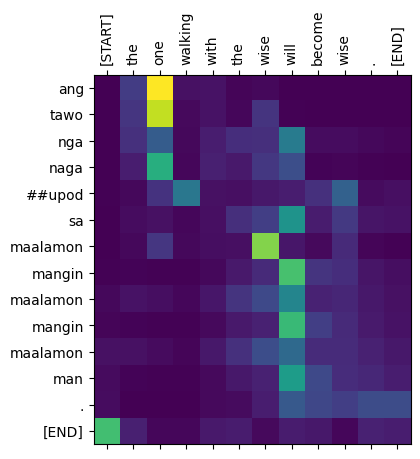

In [47]:
sentence = 'the one walking with the wise will become wise . '
ground_truth = 'ang tawo nga nagaupod sa maalamon mangin maalamon man . '
translated_text, translated_tokens, attention_weights = reloaded(sentence)
plot_attention_head(sentence, translated_tokens, attention_weights)
print_translation(sentence, translated_text, ground_truth)
rouge_score(translated_text, ground_truth)

Input:         : i avoid news reports that put that ethnic group in a negative light . 
Prediction     : indi ko gid maayo ang mga tawo nga nagasuod sa ila tribo .
Ground truth   : ginalikawan ko ang mga balita nga nagapakalain sang ila tribo . 

Precision: 0.6363636363636364
Recall: 0.5384615384615384
F1-score: 0.5833332836805598


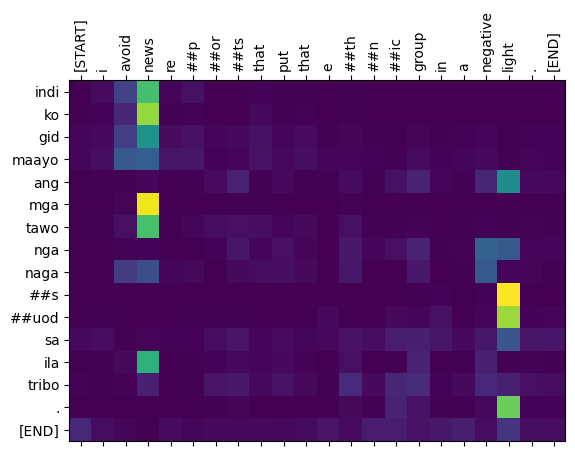

In [48]:
sentence = 'i avoid news reports that put that ethnic group in a negative light . '
ground_truth = 'ginalikawan ko ang mga balita nga nagapakalain sang ila tribo . '
translated_text, translated_tokens, attention_weights = reloaded(sentence)
plot_attention_head(sentence, translated_tokens, attention_weights)
print_translation(sentence, translated_text, ground_truth)
rouge_score(translated_text, ground_truth)

Input:         : i was happy for a moment , but then i needed yet another thrill . 
Prediction     : nalipay gid ako sa malipayon nga butang , pero daw gusto ko man ang ka delikado .
Ground truth   : nalipay gid ako sing makadali lang , pero daw gusto ko pa gid ang mas delikado . 

Precision: 0.6875
Recall: 0.6470588235294118
F1-score: 0.6666666167125841


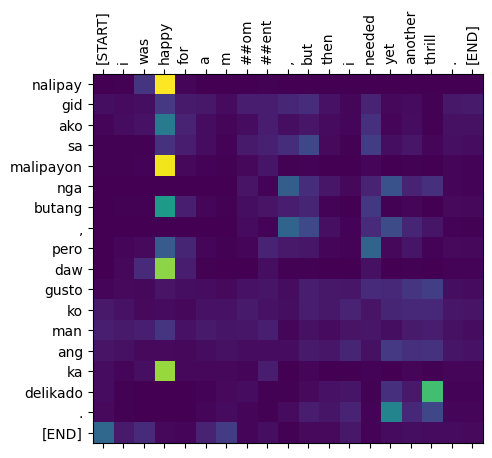

In [49]:
sentence = 'i was happy for a moment , but then i needed yet another thrill . '
ground_truth = 'nalipay gid ako sing makadali lang , pero daw gusto ko pa gid ang mas delikado . '
translated_text, translated_tokens, attention_weights = reloaded(sentence)
plot_attention_head(sentence, translated_tokens, attention_weights)
print_translation(sentence, translated_text, ground_truth)
rouge_score(translated_text, ground_truth)